In [2]:
import numpy as np
import matplotlib.pyplot as plt
from   datetime import datetime
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import linalg as la
from netCDF4 import Dataset 
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PROJ_LIB"] = "C:\\Users\\USUARIO\\Anaconda3\\Library\\share"; #fixr
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import interp1d

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from pybrain.datasets import SupervisedDataSet,UnsupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.tools.shortcuts import buildNetwork
from pybrain.structure import TanhLayer, SigmoidLayer, LinearLayer

import csv
import datetime as dt
import scipy.stats as ss

from scipy.interpolate import interp1d

In [3]:
indices = pd.read_csv('sstoi.indices', delim_whitespace=True)
indices

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1982,1,24.29,-0.17,25.87,0.24,28.30,0.00,26.72,0.15
1,1982,2,25.49,-0.58,26.38,0.01,28.21,0.11,26.70,-0.02
2,1982,3,25.21,-1.31,26.98,-0.16,28.41,0.22,27.20,-0.02
3,1982,4,24.50,-0.97,27.68,0.18,28.92,0.42,28.02,0.24
4,1982,5,23.97,-0.23,27.79,0.71,29.49,0.70,28.54,0.69
...,...,...,...,...,...,...,...,...,...,...
453,2019,10,20.02,-0.77,25.12,0.21,29.64,0.98,27.31,0.62
454,2019,11,21.32,-0.27,25.46,0.48,29.47,0.84,27.26,0.61
455,2019,12,23.16,0.34,25.47,0.33,29.50,1.01,27.07,0.50
456,2020,1,24.55,0.03,25.81,0.18,29.28,0.98,27.09,0.53


In [4]:
indices.keys()

Index(['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4', 'ANOM.2',
       'NINO3.4', 'ANOM.3'],
      dtype='object')

In [5]:
#CON PREPROCESAMIENTO

def estandarizar(serie):
    ret = (serie - np.mean(serie))/np.std(serie)
    return ret

#para entrenamiento
porc = 0.7
train4 =indices['ANOM.2'].iloc[:int(porc*(len(indices['ANOM.2'])))]
train34 = indices['ANOM.3'].iloc[:int(porc*(len(indices['ANOM.3'])))]
train3 = indices['ANOM.1'].iloc[:int(porc*(len(indices['ANOM.1'])))]
train12 = indices['ANOM'].iloc[:int(porc*(len(indices['ANOM'])))]

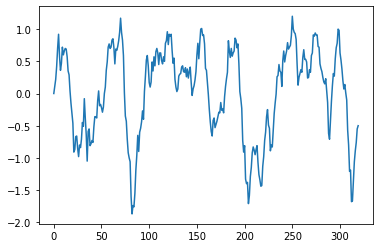

In [13]:
plt.plot(train4)

In [7]:
#para test
porc2 = 1 - porc
test4 = indices['ANOM.2'].iloc[-int(porc2*(len(indices['ANOM.2']))):]
test34 = indices['ANOM.3'].iloc[-int(porc2*(len(indices['ANOM.3']))):]
test3 = indices['ANOM.1'].iloc[-int(porc2*(len(indices['ANOM.1']))):]
test12 = indices['ANOM'].iloc[-int(porc2*(len(indices['ANOM']))):]

In [8]:
#Usar regiones 4, 3.4 y 3 para predecir niño 1.2

dsCalib=SupervisedDataSet(3,1) #tres entradas y una salida


dsCalib3=SupervisedDataSet(3,1) #tres entradas y una salida
dsCalib4=SupervisedDataSet(3,1) #tres entradas y una salida
dsCalib34=SupervisedDataSet(3,1) #tres entradas y una salida


for p1,p2,p3,res in zip(train4, train34, train3, train12):
    dsCalib.addSample((p1,p2,p3),(res,))
    dsCalib3.addSample((p1,p2,p3*0),(res,))
    dsCalib4.addSample((p1*0,p2,p3),(res,))
    dsCalib34.addSample((p1,p2*0,p3),(res,))

#Monta la red
entradas, nodos_por_capa1, salidas = 3,2,1
net = buildNetwork(entradas, nodos_por_capa1, salidas, bias=True, hiddenclass=TanhLayer) #entrada, nodos en c/ capa, salida

#Entrena la red
net.reset()

trainer = BackpropTrainer(net, dsCalib)
numero_de_conexiones = entradas*nodos_por_capa1 + nodos_por_capa1*salidas

In [10]:
iteraciones = 100
errors = []
PesosEvol = np.zeros((iteraciones, numero_de_conexiones))
activacion=[]
for j in range(iteraciones):
#     print j,}
    #Entrena y mira como evoluciona el entrenamiento
    errors.append(trainer.train()) #tasa de aprendizaje por defecto 0.01
    activacion.append(net.activateOnDataset(dsCalib))
    Pesos=[]
    for i in net.modules:
        if i.name != 'bias':
        
            for c in net.connections[i]:
                Pesos.append(c.params)
                
            
                #print c.params               
    #Guarda la evolucion de los pesos de las entradas
    Pesos = np.concatenate(np.array(Pesos)).reshape(numero_de_conexiones)
    PesosEvol[j,:]=Pesos
            #print Pesos
#PesosEvol.append(Pesos)

In [11]:
activacion=np.array(activacion)
activacion.shape

(100, 320, 1)

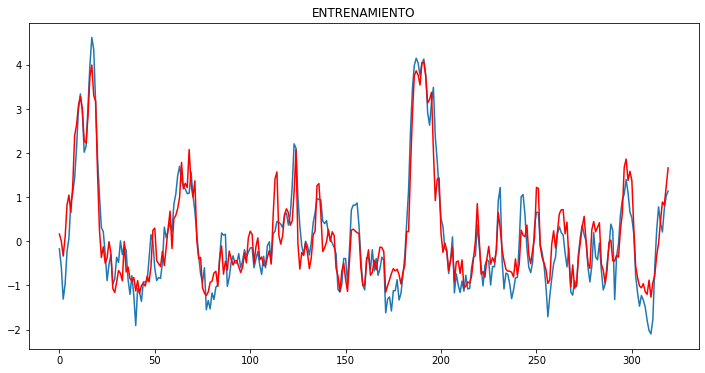

In [15]:
plt.figure(figsize=(12,6))
plt.title('ENTRENAMIENTO')
plt.plot(train12)
plt.plot(activacion[50,:], color='red')

In [695]:
PesosEvol.shape

(100, 8)

Text(0,0.5,u'Peso')

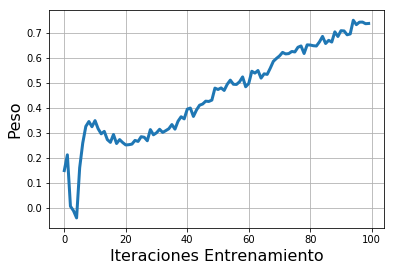

In [733]:
plt.plot(PesosEvol[:,6], lw = 3)
plt.grid(True)
plt.xlabel('Iteraciones Entrenamiento', size = 16)
plt.ylabel('Peso', size = 16)

In [731]:
for mod in net.modules:
    print "Module:", mod.name 
    if mod.paramdim > 0:
        print "--parameters:", mod.params 
    for conn in net.connections[mod]:
        #print conn.params
        print "-connection to", conn.outmod.name
        if conn.paramdim > 0:
             print "- parameters", conn.params 
    if hasattr(net, "recurrentConns"):
        print "Recurrent connections"
        for conn in net.recurrentConns:
            print 'nombre',conn.name

            print "-", conn.inmod.name, " to", conn.outmod.name
            if conn.paramdim > 0:
                print "- parameters", conn.params

Module: out
Module: in
-connection to hidden0
- parameters [ 1.10609405 -0.53738516  1.25532906 -0.19987582  1.4200747  -1.52459228]
Module: hidden0
-connection to out
- parameters [ 0.738603   -2.33554628]
Module: bias
-connection to out
- parameters [1.73069027]
-connection to hidden0
- parameters [-0.66366175  0.83425713]


In [705]:
2.6/.36

7.222222222222222

Text(0,0.5,u'Error')

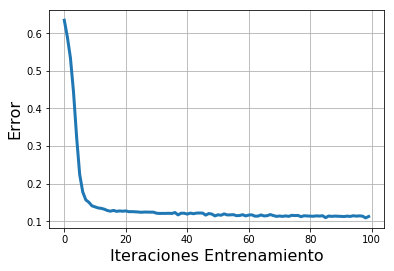

In [727]:
plt.plot(errors, lw = 3)
plt.grid(True)
plt.xlabel('Iteraciones Entrenamiento', size = 16)
plt.ylabel('Error', size = 16)

In [728]:
netSim_train = net.activateOnDataset(dsCalib)


netSim_train3 = net.activateOnDataset(dsCalib3)
netSim_train4 = net.activateOnDataset(dsCalib4)
netSim_train34 = net.activateOnDataset(dsCalib34)

# netSim_test = net.activate()

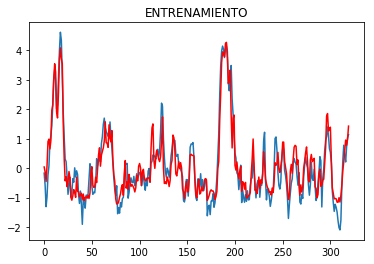

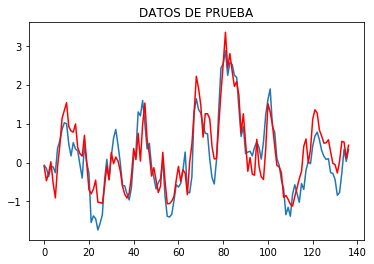

In [729]:
resultado=[]
for i in range(len(test4)):
    resultado.append(net.activate((test4.iloc[i],test34.iloc[i],test3.iloc[i])))

plt.figure(1)
plt.title('ENTRENAMIENTO')
plt.plot(train12)
plt.plot(netSim_train, color='red')

plt.figure(2)
plt.title('prueba')
plt.plot(test12.values)
plt.plot(resultado, color='red')
plt.title('DATOS DE PRUEBA');

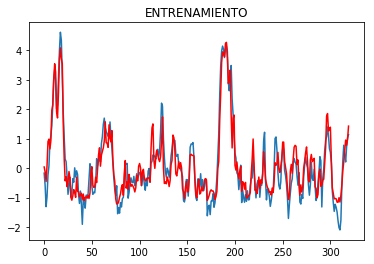

In [730]:
netSim_train2 = net.activateOnDataset(dsCalib)

plt.figure(1)
plt.title('ENTRENAMIENTO')
plt.plot(train12)
plt.plot(netSim_train2, color='red')


In [719]:
for mod in net.modules:
    print "Module:", mod.name 
    if mod.paramdim > 0:
        print "--parameters:", mod.params 
    for conn in net.connections[mod]:
        #print conn.params
        print "-connection to", conn.outmod.name
        if conn.paramdim > 0:
             print "- parameters", conn.params 
    if hasattr(net, "recurrentConns"):
        print "Recurrent connections"
        for conn in net.recurrentConns:
            print 'nombre',conn.name

            print "-", conn.inmod.name, " to", conn.outmod.name
            if conn.paramdim > 0:
                print "- parameters", conn.params

Module: out
Module: hidden0
-connection to out
- parameters [ 0.         -2.60470564]
Module: in
-connection to hidden0
- parameters [-0.16869143 -1.12303005 -1.293445   -0.23557406  1.186992   -1.40918351]
Module: bias
-connection to out
- parameters [1.57737607]
-connection to hidden0
- parameters [0.43545162 0.75882465]


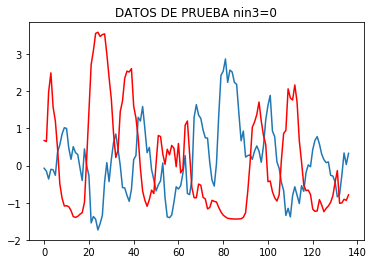

In [600]:
resultado=[]
for i in range(len(test4)):
    resultado.append(net.activate((test4.iloc[i],test34.iloc[i],test3.iloc[i]*0)))


# plt.figure(1)
# plt.title('ENTRENAMIENTO nin3 = 0')
# plt.plot(train12)
# plt.plot(netSim_train3, color='red')

plt.figure(2)
plt.title('prueba')
plt.plot(test12.values)
plt.plot(resultado, color='red')
plt.title('DATOS DE PRUEBA nin3=0');

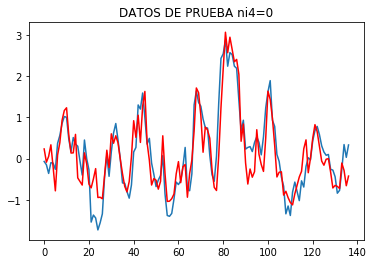

In [601]:
resultado=[]
for i in range(len(test4)):
    resultado.append(net.activate((test4.iloc[i]*0,test34.iloc[i],test3.iloc[i])))


# plt.figure(1)
# plt.title('ENTRENAMIENTO nin4 = 0')
# plt.plot(train12)
# plt.plot(netSim_train4, color='red')

plt.figure(2)
plt.title('prueba')
plt.plot(test12.values)
plt.plot(resultado, color='red')
plt.title('DATOS DE PRUEBA ni4=0');

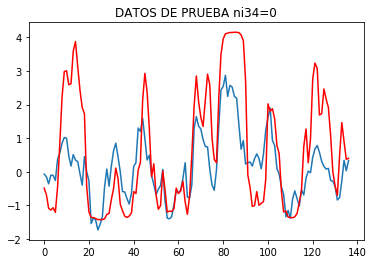

In [602]:
resultado=[]
for i in range(len(test4)):
    resultado.append(net.activate((test4.iloc[i],test34.iloc[i]*0,test3.iloc[i])))


# plt.figure(1)
# plt.title('ENTRENAMIENTO nin34 = 0')
# plt.plot(train12)
# plt.plot(netSim_train34, color='red')

plt.figure(2)
plt.title('prueba')
plt.plot(test12.values)
plt.plot(resultado, color='red')
plt.title('DATOS DE PRUEBA ni34=0');

In [566]:
conn.name

'FullConnection-224'

In [573]:
for mod in net.modules:
    print "Module:", mod.name 
    if mod.paramdim > 0:
        print "--parameters:", mod.params 
    for conn in net.connections[mod]:
        print conn.params
        print "-connection to", conn.outmod.name
        if conn.paramdim > 0:
             print "- parameters", conn.params 
    if hasattr(net, "recurrentConns"):
        print "Recurrent connections"
        for conn in net.recurrentConns:
            print 'nombre',conn.name

            print "-", conn.inmod.name, " to", conn.outmod.name
            if conn.paramdim > 0:
                print "- parameters", conn.params

Module: hidden0
[0.00318403 2.79955262]
-connection to out
- parameters [0.00318403 2.79955262]
Module: out
Module: in
[-0.89768175 -0.42998965  0.5161673   0.3230356  -1.01491226  1.35762968]
-connection to hidden0
- parameters [-0.89768175 -0.42998965  0.5161673   0.3230356  -1.01491226  1.35762968]
Module: bias
[1.35697722]
-connection to out
- parameters [1.35697722]
[-2.51443142 -0.61397983]
-connection to hidden0
- parameters [-2.51443142 -0.61397983]


In [593]:
Pesos

array([ 0.00318403,  2.79955262, -0.89768175, -0.42998965,  0.5161673 ,
        0.3230356 , -1.01491226,  1.35762968])

In [710]:
net.params

array([ 1.57737607,  0.43545162,  0.75882465, -0.16869143, -1.12303005,
       -1.293445  , -0.23557406,  1.186992  , -1.40918351, -0.36825911,
       -2.60470564])

In [711]:
p = net.params.copy()

In [712]:
p[9] = 0

In [713]:
p

array([ 1.57737607,  0.43545162,  0.75882465, -0.16869143, -1.12303005,
       -1.293445  , -0.23557406,  1.186992  , -1.40918351,  0.        ,
       -2.60470564])

In [714]:
net._setParameters(p)

In [715]:
net.params

array([ 1.57737607,  0.43545162,  0.75882465, -0.16869143, -1.12303005,
       -1.293445  , -0.23557406,  1.186992  , -1.40918351,  0.        ,
       -2.60470564])

## NUEVA RED "SIMPLIFICADA"

In [740]:
#Usar regiones 4, 3.4 y 3 para predecir niño 1.2

dsCalib=SupervisedDataSet(2,1) #tres entradas y una salida


dsCalib3=SupervisedDataSet(2,1) #tres entradas y una salida
dsCalib4=SupervisedDataSet(2,1) #tres entradas y una salida

dsCalib34=SupervisedDataSet(2,1) #tres entradas y una salida

for p1,p3,res in zip(train4,  train3, train12):
    dsCalib.addSample((p1,p3),(res,))
    dsCalib3.addSample((p1,p3*0),(res,))
    dsCalib4.addSample((p1*0,p3),(res,))
    dsCalib34.addSample((p1,p3),(res,))

#Monta la red
entradas, nodos_por_capa1, salidas = 2,2,1
net = buildNetwork(entradas, nodos_por_capa1, salidas, bias=True, hiddenclass=TanhLayer) #entrada, nodos en c/ capa, salida
#Entrena la red
net.reset()

trainer = BackpropTrainer(net, dsCalib)
numero_de_conexiones = entradas*nodos_por_capa1 + nodos_por_capa1*salidas

In [741]:
net.reset()
iteraciones = 100
errors = []
PesosEvol = np.zeros((iteraciones, numero_de_conexiones))
activacion=[]
for j in range(iteraciones):
    print j,
    #Entrena y mira como evoluciona el entrenamiento
    errors.append(trainer.train()) #tasa de aprendizaje por defecto 0.01
    activacion.append(net.activateOnDataset(dsCalib))
    Pesos=[]
    for i in net.modules:
        if i.name != 'bias':
        
            for c in net.connections[i]:
                Pesos.append(c.params)
                
            
                #print c.params               
    #Guarda la evolucion de los pesos de las entradas
    Pesos = np.concatenate(np.array(Pesos)).reshape(numero_de_conexiones)
    PesosEvol[j,:]=Pesos
            #print Pesos
#PesosEvol.append(Pesos)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


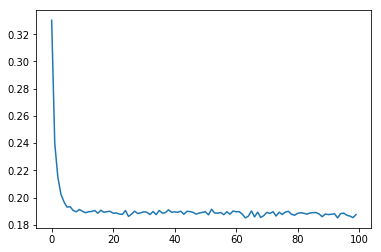

In [742]:
plt.plot(errors)

In [743]:
netSim_train = net.activateOnDataset(dsCalib)

netSim_train3 = net.activateOnDataset(dsCalib3)
netSim_train4 = net.activateOnDataset(dsCalib4)
netSim_train34 = net.activateOnDataset(dsCalib34)


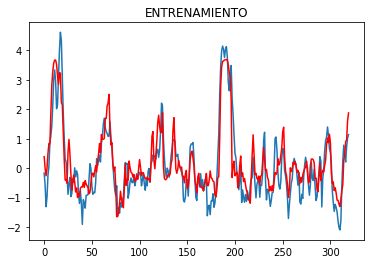

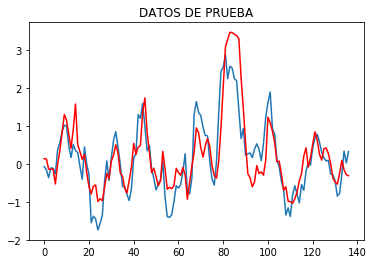

In [745]:
resultado=[]
for i in range(len(test4)):
    resultado.append(net.activate((test4.iloc[i], test3.iloc[i])))


plt.figure(1)
plt.title('ENTRENAMIENTO')
plt.plot(train12)
plt.plot(netSim_train, color='red')

plt.figure(2)
plt.title('prueba')
plt.plot(test12.values)
plt.plot(resultado, color='red')
plt.title('DATOS DE PRUEBA');

(0, 30)

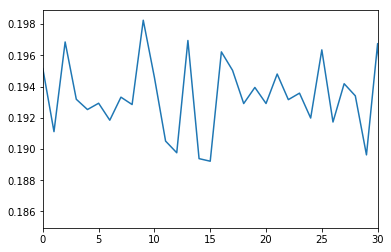

In [615]:
plt.plot(errors)
plt.xlim(0,30)

In [561]:
import matplotlib.cm as cm

def plot_colourline(x,y,c,vmin,vmax,lw=2.5,zorder=5,colormap=cm.jet):
    c = colormap((c-vmin)/(vmax-vmin))
#     print c.shape
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i],lw=lw,zorder=zorder)
    return 

class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = pyplot.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        pyplot.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in xrange(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (
                self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2, coeficiente=None, vmin=0, vmax=1):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
#         line = plot_colourline((neuron1.x - x_adjustment, neuron2.x + x_adjustment),
#                              (neuron1.y - y_adjustment, neuron2.y + y_adjustment), Pesos, )
        colormap=cm.jet
        c = colormap((coeficiente-vmin)/(vmax-vmin))
        line = pyplot.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment),
                             (neuron1.y - y_adjustment, neuron2.y + y_adjustment),c=c)
        pyplot.gca().add_line(line)

    def draw(self, layerType=0, coeficientes=None):
        for neuron in self.neurons:
            neuron.draw(self.neuron_radius)
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron, coeficientes[i]\
                                                   vmin=np.min(coeficientes), vmax=np.max(coeficientes))
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            pyplot.text(x_text, self.y, 'Input Layer', fontsize=12)
        elif layerType == -1:
            pyplot.text(x_text, self.y, 'Output Layer', fontsize=12)
        else:
            pyplot.text(x_text, self.y, 'Hidden Layer ' + str(layerType), fontsize=12)


class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        pyplot.figure()
        for i in range(len(self.layers)):
            layer = self.layers[i]
            if i == len(self.layers) - 1:
                i = -1
            layer.draw(i)
        pyplot.axis('scaled')
        pyplot.axis('off')
        pyplot.title('Neural Network architecture', fontsize=15)
        pyplot.show()


class NNVisualizer():
    def __init__(self, neural_network):
        self.neural_network = neural_network

    def draw(self):
        widest_layer = max(self.neural_network)
        network = NeuralNetwork(widest_layer)
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()


class PybrainNNVisualizer():
    def __init__(self, neural_network):
        """
        :type neural_network: Network
        """
        self.neural_network = neural_network

    def draw(self, coeficientes=None):
        
        widest_layer = max([layer.dim for layer in self.neural_network.modules])
        network = NeuralNetwork(widest_layer)
        for layer in self.neural_network.modulesSorted:
            if type(layer) is BiasUnit:
                continue
            network.add_layer(layer.dim)
        network.draw()

SyntaxError: invalid syntax (<ipython-input-561-2487d333c5dc>, line 73)

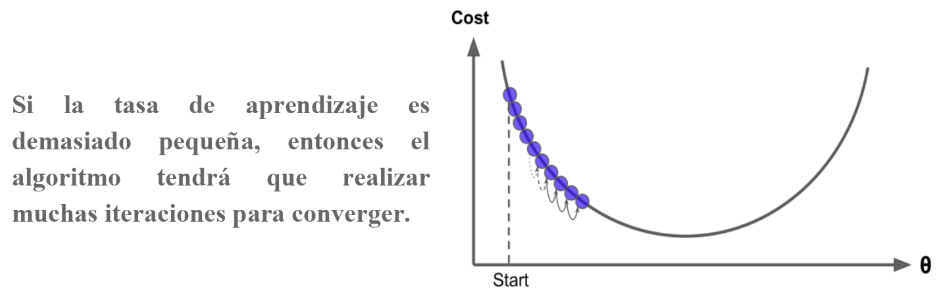

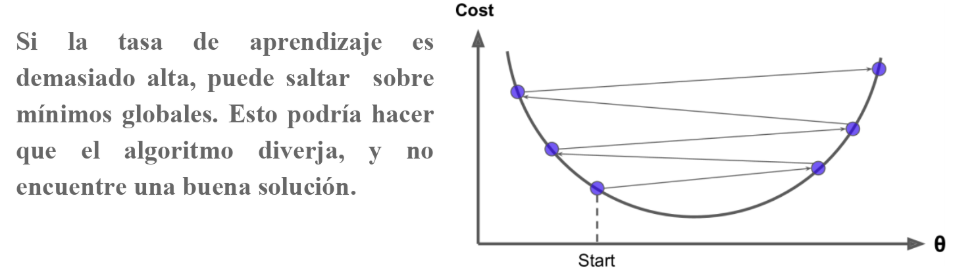

## SVC

In [421]:
from sklearn import datasets, svm, metrics
# iris = datasets.load_iris()
digits = datasets.load_digits()
import matplotlib.pyplot as plt

In [423]:
digits.images.shape

(1797, 8, 8)

In [424]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

Text(0.5,1,u'Target: 4')

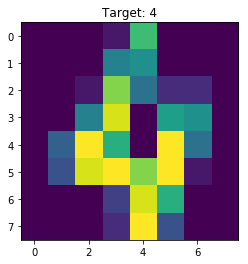

In [429]:
i = 4
plt.imshow(digits.images[i])
plt.title('Target: '+str(digits.target[i]))

In [432]:
digits.target.shape[0]

1797

In [434]:
data = digits.images.reshape([digits.target.shape[0],8*8])

In [435]:
n_samples = len(digits.target)

In [476]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.00001,C=1)
classifier.fit(data[:n_samples // 2], digits.target[:n_samples //2])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [477]:
# Now predict the value of the digit on the second half:
expected = digits.target[n_samples // 2:]
predicted = classifier.predict(data[n_samples // 2:])

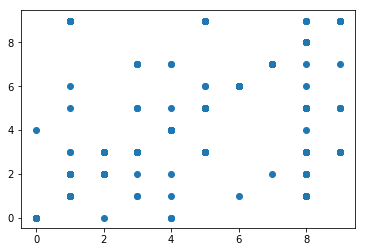

In [478]:
plt.scatter(expected,predicted)

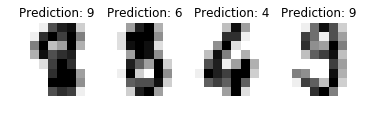

In [479]:
images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()


In [480]:
digits.target[n_samples // 2:][:4]

array([8, 8, 4, 9])

In [481]:
print classifier.support_vectors_.shape
print data[:n_samples // 2].shape

(895, 64)
(898, 64)


In [482]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 65 11  2  0  1  1  0  0 11]
 [ 1  0 74 11  0  0  0  0  0  0]
 [ 0  2  1 80  0  3  0  5  0  0]
 [ 3  1  1  0 84  1  0  2  0  0]
 [ 0  0  0 13  0 69  2  0  0  7]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  1  0  0  0  0 88  0  0]
 [ 0 23  6 15  1  9  1  1 27  5]
 [ 0  0  0 34  0  4  0  1  0 53]]


## Support vector regression

In [491]:
def MSE_FULL(Observados, Simulados):
    return np.sum(((Observados-Simulados)**2)/len(Observados))


In [398]:
indices

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1982,1,24.29,-0.17,25.87,0.24,28.30,0.00,26.72,0.15
1,1982,2,25.49,-0.58,26.38,0.01,28.21,0.11,26.70,-0.02
2,1982,3,25.21,-1.31,26.98,-0.16,28.41,0.22,27.20,-0.02
3,1982,4,24.50,-0.97,27.68,0.18,28.92,0.42,28.02,0.24
4,1982,5,23.97,-0.23,27.79,0.71,29.49,0.70,28.54,0.69
5,1982,6,22.89,0.07,27.46,1.03,29.76,0.92,28.75,1.10
6,1982,7,22.47,0.87,26.44,0.82,29.38,0.58,28.10,0.88
7,1982,8,21.75,1.10,26.15,1.16,29.04,0.36,27.93,1.11
8,1982,9,21.80,1.44,26.52,1.67,29.16,0.47,28.11,1.39
9,1982,10,22.94,2.12,27.11,2.19,29.38,0.72,28.64,1.95


In [504]:
len_train = 300

In [505]:
X = indices[['ANOM.1','ANOM.2','ANOM.3']][:len_train].values
Y = indices['ANOM'][:len_train].values

In [506]:
X_test = indices[['ANOM.1','ANOM.2','ANOM.3']][len_train:].values
Y_test = indices['ANOM'][len_train:].values

In [507]:
MSE_1 = []
MSE_2 = []

K = []
EI = []
GAMMA = []
CI = []

C_2d_range = [0.1,1,10]
gamma_2d_range = [0.001,0.01,0.1,1,10]

for k in ['rbf', 'sigmoid']:
    for Ci in C_2d_range:
        for ei in [0.01,0.1,1,10]:
            for gamma in gamma_2d_range:
                clf = SVR(C=Ci, epsilon=ei,kernel=k,gamma=gamma)
                clf.fit(X, Y)
                y0 = clf.predict(X)
                y1 = clf.predict(X_Test)
                
                
                MSE_1.append(MSE_FULL(Y,y0))
                MSE_2.append(MSE_FULL(Y_Test,y1))

                K.append(k)
                EI.append(ei)
                GAMMA.append(gamma)
                CI.append(Ci)

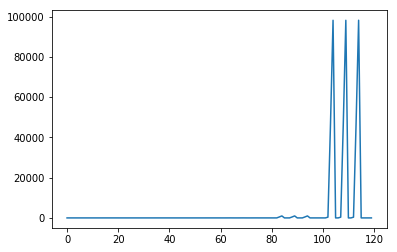

In [508]:
plt.plot(np.array(MSE_1))
# plt.plot(np.array(MSE_2))

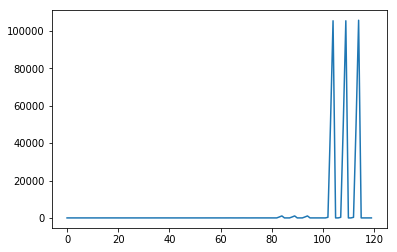

In [509]:
# plt.plot(np.array(MSE_1))
plt.plot(np.array(MSE_2))

In [510]:
where = np.argmin(MSE_1)

In [511]:
k = K[where]
e = EI[where]
gamma = GAMMA[where]
C = CI[where]

In [512]:
clf = SVR(C=C, epsilon=e,kernel=k,gamma=gamma)
clf.fit(X, Y)
y0 = clf.predict(X)
y1 = clf.predict(X_Test)

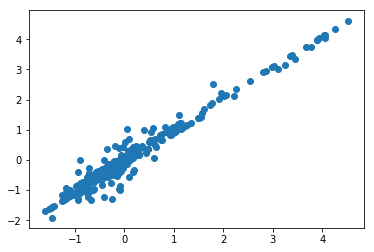

In [513]:
plt.scatter(y0,Y)

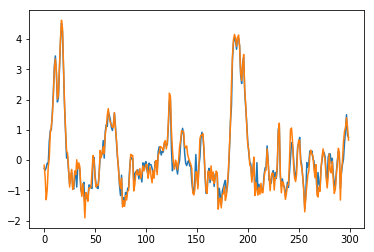

In [514]:
plt.plot(y0)
plt.plot(Y)

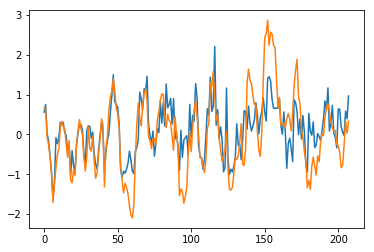

In [515]:
plt.plot(y1)
plt.plot(Y_Test)

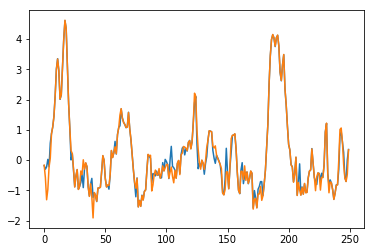

In [417]:
plt.plot(y0)
plt.plot(Y)

##ATRACTOR DE LORENZ



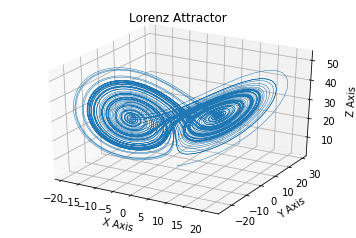

In [625]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


def lorenz(x, y, z, s=10, r=28, b=2.667):
    '''
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    '''
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

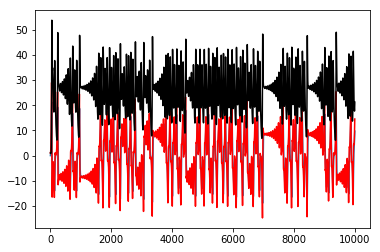

In [629]:
plt.plot(xs)
plt.plot(ys,c='r')
plt.plot(zs, c='k')

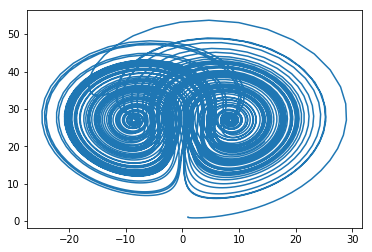

In [631]:
plt.plot(ys,zs)

In [634]:
info = []
for i in range(len(xs)):
    info.append(sklearn.metrics.mutual_info_score(xs, np.roll(xs,i)))

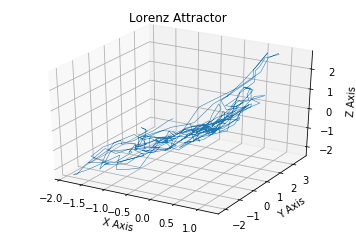

In [637]:
# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(train3, train34, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

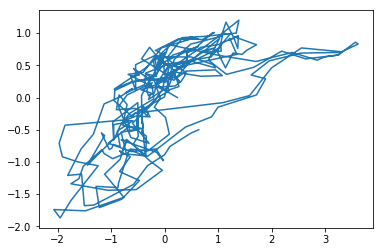

In [638]:
plt.plot(train3,train4)

In [623]:

xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (0., 1., 1.05)
num_steps=100
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)


# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(xs, ys, zs, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0